In [1]:
import dash
# import dash_auth
# from users import USERNAME_PASSWORD_PAIRS
from dash import dcc
from dash import html
import plotly
import dash_bootstrap_components as dbc
# import dash_daq as dq
from jupyter_dash import JupyterDash
from dash import Dash
import pandas as pd  
import joblib
import base64, io, os
from dash import  dash_table
import dash
import pandas as pd
from dash import dash_table
import pickle
from dash.dependencies import Input, Output, State, ALL, MATCH
import json
# from functools import reduce
from dash import Input, Output, State, html
from tqdm.notebook import trange, tqdm
import pickle
import numpy as np
import pandas as pd
# from cryptography.fernet import Fernet
import json
import io, base64, os
import pandas as pd
import datetime
import time
import re
import plotly.express as px
import plotly.graph_objects as go
from dash_canvas.utils import array_to_data_url

import geopandas
import tifffile as tiff
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathpretrain.utils import generate_tissue_mask
import scipy.ndimage as ndimage
from skimage.util import compare_images
from skimage.measure import regionprops_table
from skimage import exposure
import tempfile
import matplotlib.image as mpimg
from skimage import data, draw
from io import BytesIO
import copy
from matplotlib.colors import Normalize as Colors_Normalize
# from scipy import ndimage

In [2]:
with open("./data/match_dict.pkl", "rb") as file:
    match_dict = pickle.load(file)

annotation_data = geopandas.read_file("./data/_SS12251_140745.geojson")
im_large = tiff.imread("./data/_SS12251_140745.svs")
im_medium = cv2.resize(im_large, None, fx=1/7, fy=1/7)
im_small = cv2.resize(im_large, None, fx=1/15, fy=1/15)

with open("./data/011320_002_N_HR_dict.pkl", "rb") as input_file:
    metal_data = pickle.load(input_file)

In [3]:
def crop_slide(image_array):
#     slide_file = list(filter(lambda x: match_dict[x] == imageId, match_dict))[0]    
    im_large=image_array#tifffile.imread(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/metals/breast/new_slide_images_4_6_23/{slide_file}.svs")

    tissue_mask=generate_tissue_mask(im_large*5,compression=32.,threshold=240,kernel=10,gray_before_close=True) 
    compression=32
    
    # Metal image is only portion of slide
#     if (imageId == "092619_007_T_HER2"):    
        
#     if (imageId == "102720_003_T_TNBC"):
#         labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
#         lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
#         xmin,ymin,xmax,ymax=(lbl_table.iloc[1][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
#     else:  
    labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
    lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
    xmin,ymin,xmax,ymax=(lbl_table.iloc[0][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
    
    im_large_crop=im_large[xmin:xmax,ymin:ymax].copy()
    im_large_crop[~tissue_mask[xmin:xmax,ymin:ymax]]=255
    
    return im_large_crop, [[xmin, ymin], [xmax, ymax]], tissue_mask

In [4]:
im_large_crop, minmax_list, tissue_mask = crop_slide(im_large)
im_small_crop = cv2.resize(im_large_crop, None, fx=1/15, fy=1/15)

hne_image = px.imshow(im_small_crop)
metal_image = px.imshow(np.log(metal_data['metals']['Ca44'])+10, color_continuous_scale='jet')

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in log

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in log



In [5]:
annotation_data['annot']=annotation_data['classification'].map(lambda x: x.get("name","none"))

gp2=annotation_data.copy()
gp2['geometry']=gp2['geometry'].scale(1/7,1/7,origin=(0,0))
gp2['coords'] = gp2['geometry'].apply(lambda x: x.representative_point().coords[:])
gp2['coords'] = [coords[0] for coords in gp2['coords']]

In [8]:
app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

markdown_text_title = '''
# **Metals Demo**
'''

all_color_list = px.colors.qualitative.Dark24
result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})
newest_result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})

all_relayout_data = {'shapes': [], 'dragmode': ''}

type_to_color_dict = {'immune': all_color_list[0], 'tumor': all_color_list[1]}
color_to_type_dict = {all_color_list[0]: 'immune', all_color_list[1]: 'tumor'}

tab_Data_content = dbc.Card(
    dbc.CardBody(
        [
            html.P("This is Data tab", className="card-text"),
        ]
    ),
    className="mt-3",
)

image_no_axis_layout = go.Layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

hne_image.update_layout(image_no_axis_layout)
metal_image.update_layout(image_no_axis_layout)
hne_image.update_layout(title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'))

def path_to_indices(path, scale_factor):
    """From SVG path to numpy array of coordinates, each row being a (row, col) point
    """
    indices_str = [
        el.replace("M", "").replace("Z", "").split(",") for el in path.split("L")
    ]
    return np.rint(np.array(indices_str, dtype=float)*(1/scale_factor)).astype(np.int)

def path_to_mask(path, shape, scale_factor, padded_rows, padded_columns):
    path_work = path_to_indices(path, scale_factor)
    path_work[:, 0][path_work[:, 0] == padded_columns] = (padded_columns-1)
    path_work[:, 1][path_work[:, 1] == padded_rows] = (padded_rows-1)
    cols, rows = path_work.T
    rr, cc = draw.polygon(rows, cols)
    mask = np.zeros(shape, dtype=np.bool)
    mask[rr, cc] = True
    mask = ndimage.binary_fill_holes(mask)
    return mask

def update_metal_image(selected_metal, 
                       np_log, 
                      ):
    if np_log == 'With np log transform':
        original_metal_image = metal_data['metals'][selected_metal]
        cmap_jet = plt.cm.get_cmap('jet')
        original_metal_image[original_metal_image <= 0] = 0.000001
        original_metal_image = np.nan_to_num(original_metal_image, nan=0.000001)
        original_metal_image = np.log(original_metal_image)+10
        original_metal_image_normalized = (original_metal_image - original_metal_image.min()) / (original_metal_image.max() - original_metal_image.min())
        metal_image_data = cmap_jet(original_metal_image_normalized)
        metal_image_data = metal_image_data[:, :, :3]
        metal_image = px.imshow(metal_image_data)
    else:
        metal_image_data = metal_data['metals'][selected_metal]
        metal_image = px.imshow(metal_image_data, color_continuous_scale='jet')
        metal_image.layout.coloraxis.showscale = False
    metal_image.update_layout(image_no_axis_layout)
    metal_image.update_layout(title=dict(text="Metal Image - {}".format(selected_metal), x=0.5, y=0.95, xanchor='center'))
    return metal_image

tab_Visualization_content = dbc.Card(
    dbc.CardBody(
        [
            dbc.Row(
            [
                dbc.Col(dcc.Graph(id="hne_image", figure=hne_image,), 
                        width=6),
                dbc.Col(dcc.Graph(id="metal_image", figure=metal_image,),
                        width=6),
            ]
        ),
            dbc.Row([
                dcc.Dropdown(
                            id='metal_dropdown',
                            options=list(metal_data['metals'].keys()),
                            value='Ca44',
                            searchable=True, 
                            style={'width': '110px'},
                                ),
                dcc.Dropdown(
                            id='np_log_dropdown',
                            options=['With np log transform', 'Without np log transform'],
                            value='With np log transform',
                            style={'width': '300px'},
                                ),
            ], justify="end",),
        ]
    ),
    className="mt-3",
)

tab_Coregister_content = dbc.Card(
    dbc.CardBody(
        [
            html.P("This is Coregister tab", className="card-text"),
        ]
    ),
    className="mt-3",
)

original_image = px.imshow(im_medium)
original_image.update_layout(image_no_axis_layout)
original_image.update_layout(title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'))
original_image.update_layout(margin={'l': 0, 'r': 0, 't': 0, 'b': 0})


padded_rows = 1000
padded_columns = 1600

original_metal_image = metal_data['metals']['Ca44']
rows_padding = max(0, padded_rows - original_metal_image.shape[0])
columns_padding = max(0, padded_columns - original_metal_image.shape[1])
top_pad = rows_padding // 2
bottom_pad = rows_padding - top_pad
left_pad = columns_padding // 2
right_pad = columns_padding - left_pad
padded_metal_image = np.pad(original_metal_image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image[padded_metal_image <= 0] = 0.000001
padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
padded_metal_image = np.log(padded_metal_image)+10
padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]

blank_figure = go.Figure()

blank_img_width = padded_columns
blank_img_height = padded_rows
scale_factor = 0.35

blank_figure.add_trace(
    go.Scatter(
        x=[0, blank_img_width * scale_factor],
        y=[0, blank_img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

blank_figure.update_xaxes(
    visible=False,
    range=[0, blank_img_width * scale_factor]
)

blank_figure.update_yaxes(
    visible=False,
    range=[0, blank_img_height * scale_factor],
    scaleanchor="x",
)
    
blank_figure.add_layout_image(
    dict(
        x=0,
        sizex=blank_img_width * scale_factor,
        y=blank_img_height * scale_factor,
        sizey=blank_img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
)

blank_figure.update_layout(
    width=blank_img_width * scale_factor,
    height=blank_img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

image_annotation_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Annotation area")),
        dbc.CardBody(
            [
                dcc.Graph(
                    id="annotate_metal_image",
                    figure=blank_figure,
                    config={"modeBarButtonsToAdd": ["drawrect", "eraseshape", "drawclosedpath",], 
                            'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'zoomIn2d', 'zoomOut2d']},
                ),
                dcc.Store(id='annotation_store', data=[]),
                dbc.Row([
                    html.Div("color map: ", style={'font-weight': 'bold'}),
                ]),
                dbc.Row([
                    dcc.Dropdown(
                                id='annotation_colormap',
                                options=[{'label': 'viridis', 'value': 'viridis'}, 
                                         {'label': 'jet', 'value': 'jet'}, 
                                         {'label': 'plasma', 'value': 'plasma'}],
                                value='jet',
                                style={'width': '150px'}, 
                                    ),
                    dbc.Button("Update", id="update_annotation_customize_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '100px'}, 
                               className="me-1", 
                              ),
                ], justify="between",),
                dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                    dbc.Input(id="vmin_input", placeholder="vmin", 
                              type="number", 
                              style={'width': '120px'}, 
                             ),
                    dbc.Input(id="vmax_input", placeholder="vmax", 
                              type="number", 
                              style={'width': '120px'}, 
                             ),
                ], justify="start",),
            ]
        ),
        dbc.CardFooter(
            [
                dcc.Markdown(
                    "To annotate the above image"
                    "rectangle .\n\n"
                    "**Choose metals**:"
                ),
                dbc.Row([
                    dbc.Input(id="type_input", placeholder="Add new type", 
                              type="text", 
                              style={'width': '170px'}, 
                             ),
                    dbc.Button("Add Type", id="add_type_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '100px'}, 
                               className="me-1", 
                              ),
                    dcc.Dropdown(
                                id='type_dropdown_annotation',
                                options=[{'label': 'immune', 'value': 'immune'}, 
                                         {'label': 'tumor', 'value': 'tumor'}],
                                value='immune',
                                style={'width': '150px'}, 
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_annotation',
                                options=list(metal_data['metals'].keys()),
                                value='Ca44',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                ], justify="center",),
            ]
        ),]
)

annotation_result_table = dbc.Table.from_dataframe(result_df, striped=True, bordered=True, hover=True)

annotated_data_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Table")),
        dbc.CardBody(
            [
                html.Div(id='table_container', children = annotation_result_table),
            ]
        ),
        dbc.CardFooter(
            [
                dbc.Button('Calculate Result', id='update_table_button', 
                           size="sm", n_clicks=0, className="me-1"), 
                dbc.Button("Download Table", id="export_data",
                           size="sm", n_clicks=0, className="me-1"),
                dcc.Download(id="download_dataframe_csv"),
            ]
        ),]
)

image_annotation_table = dbc.Row(
                                [
                                dbc.Col(dcc.Graph(figure=original_image), width=4),
                                dbc.Col(image_annotation_card, width=5),
                                dbc.Col(annotated_data_card, md=3),
                                ], 
                                justify="start",)

tab_Measure_content = dbc.Card(
    dbc.CardBody(
        [
            image_annotation_table,
        ]
    ),
    className="mt-3",)

all_tabs = dbc.Tabs(
    [
        dbc.Tab(tab_Data_content, label="Data"),
        dbc.Tab(tab_Visualization_content, label="Visualization"),
        dbc.Tab(tab_Coregister_content, label="Co-register"),
        dbc.Tab(tab_Measure_content, label="Measure"),
    ]
)

app.layout = html.Div([dcc.Markdown(children=markdown_text_title),
                       all_tabs])

@app.callback(
    Output('metal_image', 'figure'),
    [Input('metal_dropdown', 'value'), 
     Input('np_log_dropdown', 'value')]
)

def update_metal_image_callback(selected_metal, np_log):
    return update_metal_image(selected_metal, np_log)

@app.callback(
    Output('type_dropdown_annotation', 'options'),
    Input('add_type_button', 'n_clicks'),
    State('type_input', 'value'), 
    State('type_dropdown_annotation', 'options')
)

def add_annotation_type(n_clicks, type_input, previous_types):
    if n_clicks > 0 and type_input:
        new_option = {'label': type_input, 'value': type_input}
        if new_option not in previous_types:
            previous_types.append(new_option)

            global type_to_color_dict
            global color_to_type_dict
            already_types_num = len(list(type_to_color_dict.keys()))
            type_to_color_dict[str(type_input)] = all_color_list[already_types_num]
            color_to_type_dict[all_color_list[already_types_num]] = str(type_input)
        
    return previous_types

@app.callback(
    Output('annotate_metal_image', 'figure'),
    Input('metal_dropdown_annotation', 'value'),
    Input('annotate_metal_image', 'relayoutData'),
    Input('type_dropdown_annotation', 'value'),
    Input('update_annotation_customize_button', 'n_clicks'),
    Input('annotation_colormap', 'value'),
    State('vmin_input', 'value'), 
    State('vmax_input', 'value')
)

def update_annotation_callback(selected_metal, 
                               relayout_data,
                               annotation_type,
                               n_clicks,
                               colormap,
                               vmin,
                               vmax,
                              ):
    if n_clicks < 1:
        padded_rows = 1000
        padded_columns = 1600

        original_metal_image = metal_data['metals'][selected_metal]
        rows_padding = max(0, padded_rows - original_metal_image.shape[0])
        columns_padding = max(0, padded_columns - original_metal_image.shape[1])
        top_pad = rows_padding // 2
        bottom_pad = rows_padding - top_pad
        left_pad = columns_padding // 2
        right_pad = columns_padding - left_pad
        padded_metal_image = np.pad(original_metal_image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')
        padded_metal_image[padded_metal_image <= 0] = 0.000001
        padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
        padded_metal_image = np.log(padded_metal_image)+10
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
        cmap_jet = plt.cm.get_cmap('jet')
        padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        
        target_color_to_white = padded_metal_image_rgb[0, 0, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        blank_figure = go.Figure()

        blank_img_width = padded_columns
        blank_img_height = padded_rows
        scale_factor = 0.35

        blank_figure.add_trace(
            go.Scatter(
                x=[0, blank_img_width * scale_factor],
                y=[0, blank_img_height * scale_factor],
                mode="markers",
                marker_opacity=0
            )
        )
        blank_figure.update_xaxes(
            visible=False,
            range=[0, blank_img_width * scale_factor]
        )
        blank_figure.update_yaxes(
            visible=False,
            range=[0, blank_img_height * scale_factor],
            scaleanchor="x",
        )
        blank_figure.add_layout_image(
            dict(
                x=0,
                sizex=blank_img_width * scale_factor,
                y=blank_img_height * scale_factor,
                sizey=blank_img_height * scale_factor,
                xref="x",
                yref="y",
                opacity=1.0,
                layer="below",
                sizing="stretch",
                source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
        )
        blank_figure.update_layout(
            width=blank_img_width * scale_factor,
            height=blank_img_height * scale_factor,
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
        )
        if relayout_data:
            if 'shapes' in list(relayout_data.keys()):
                if len(relayout_data['shapes']) > len(all_relayout_data['shapes']):
                    append_relayout = relayout_data['shapes'][-1]
                    append_relayout['line']['color'] = type_to_color_dict[annotation_type]
                    all_relayout_data['shapes'].append(append_relayout)
                elif len(relayout_data['shapes']) < len(all_relayout_data['shapes']):
                    all_relayout_data['shapes'] = relayout_data['shapes']
            if 'dragmode' in list(relayout_data.keys()):
                all_relayout_data['dragmode'] = relayout_data['dragmode']
            for one_shape in all_relayout_data['shapes']:
                one_shape['line']['width'] = 2
            blank_figure['layout'].update(all_relayout_data)
        return blank_figure
    elif n_clicks >= 1 and (not vmin or not vmax):
        padded_rows = 1000
        padded_columns = 1600

        original_metal_image = metal_data['metals'][selected_metal]
        rows_padding = max(0, padded_rows - original_metal_image.shape[0])
        columns_padding = max(0, padded_columns - original_metal_image.shape[1])
        top_pad = rows_padding // 2
        bottom_pad = rows_padding - top_pad
        left_pad = columns_padding // 2
        right_pad = columns_padding - left_pad
        padded_metal_image = np.pad(original_metal_image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')

        padded_metal_image[padded_metal_image <= 0] = 0.000001
        padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
        padded_metal_image = np.log(padded_metal_image)+10
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
        cmap_trans = plt.cm.get_cmap(colormap)
        padded_metal_image_rgb = cmap_trans(padded_metal_image_normalized)
        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        
        target_color_to_white = padded_metal_image_rgb[0, 0, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

        blank_figure = go.Figure()

        blank_img_width = padded_columns
        blank_img_height = padded_rows
        scale_factor = 0.35

        blank_figure.add_trace(
            go.Scatter(
                x=[0, blank_img_width * scale_factor],
                y=[0, blank_img_height * scale_factor],
                mode="markers",
                marker_opacity=0
            )
        )

        blank_figure.update_xaxes(
            visible=False,
            range=[0, blank_img_width * scale_factor]
        )

        blank_figure.update_yaxes(
            visible=False,
            range=[0, blank_img_height * scale_factor],
            scaleanchor="x",
        )

        blank_figure.add_layout_image(
            dict(
                x=0,
                sizex=blank_img_width * scale_factor,
                y=blank_img_height * scale_factor,
                sizey=blank_img_height * scale_factor,
                xref="x",
                yref="y",
                opacity=1.0,
                layer="below",
                sizing="stretch",
                source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
        )

        blank_figure.update_layout(
            width=blank_img_width * scale_factor,
            height=blank_img_height * scale_factor,
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
        )
        
        if relayout_data:
            if 'shapes' in list(relayout_data.keys()):
                if len(relayout_data['shapes']) > len(all_relayout_data['shapes']):
                    append_relayout = relayout_data['shapes'][-1]
                    append_relayout['line']['color'] = type_to_color_dict[annotation_type]
                    all_relayout_data['shapes'].append(append_relayout)
                elif len(relayout_data['shapes']) < len(all_relayout_data['shapes']):
                    all_relayout_data['shapes'] = relayout_data['shapes']
            if 'dragmode' in list(relayout_data.keys()):
                all_relayout_data['dragmode'] = relayout_data['dragmode']
            for one_shape in all_relayout_data['shapes']:
                one_shape['line']['width'] = 2
            blank_figure['layout'].update(all_relayout_data)
        return blank_figure
    elif n_clicks >= 1 and vmin and vmax:
        padded_rows = 1000
        padded_columns = 1600

        original_metal_image = metal_data['metals'][selected_metal]
        rows_padding = max(0, padded_rows - original_metal_image.shape[0])
        columns_padding = max(0, padded_columns - original_metal_image.shape[1])
        top_pad = rows_padding // 2
        bottom_pad = rows_padding - top_pad
        left_pad = columns_padding // 2
        right_pad = columns_padding - left_pad
        padded_metal_image = np.pad(original_metal_image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')

    #     cmap_jet = plt.cm.get_cmap('jet')
        padded_metal_image[padded_metal_image <= 0] = 0.000001
        padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
        padded_metal_image = np.log(padded_metal_image)+10
        
        c_norm = Colors_Normalize(vmin=vmin, vmax=vmax)
        padded_metal_image_normalized = c_norm(padded_metal_image)
        
#         padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
#         cmap_jet = plt.cm.get_cmap('jet')
        cmap_trans = plt.cm.get_cmap(colormap)
        padded_metal_image_rgb = cmap_trans(padded_metal_image_normalized)
        padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]
        
        target_color_to_white = padded_metal_image_rgb[0, 0, :]
        replacement_color_to_white = np.array([1, 1, 1])
        mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
        padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

#         print(padded_metal_image_rgb)

        blank_figure = go.Figure()

        blank_img_width = padded_columns
        blank_img_height = padded_rows
        scale_factor = 0.35

        blank_figure.add_trace(
            go.Scatter(
                x=[0, blank_img_width * scale_factor],
                y=[0, blank_img_height * scale_factor],
                mode="markers",
                marker_opacity=0
            )
        )

        blank_figure.update_xaxes(
            visible=False,
            range=[0, blank_img_width * scale_factor]
        )

        blank_figure.update_yaxes(
            visible=False,
            range=[0, blank_img_height * scale_factor],
            scaleanchor="x",
        )

        blank_figure.add_layout_image(
            dict(
                x=0,
                sizex=blank_img_width * scale_factor,
                y=blank_img_height * scale_factor,
                sizey=blank_img_height * scale_factor,
                xref="x",
                yref="y",
                opacity=1.0,
                layer="below",
                sizing="stretch",
                source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
        )

        blank_figure.update_layout(
            width=blank_img_width * scale_factor,
            height=blank_img_height * scale_factor,
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
        )

        if relayout_data:
            if 'shapes' in list(relayout_data.keys()):
                if len(relayout_data['shapes']) > len(all_relayout_data['shapes']):
                    append_relayout = relayout_data['shapes'][-1]
                    append_relayout['line']['color'] = type_to_color_dict[annotation_type]
                    all_relayout_data['shapes'].append(append_relayout)
                elif len(relayout_data['shapes']) < len(all_relayout_data['shapes']):
                    all_relayout_data['shapes'] = relayout_data['shapes']
            if 'dragmode' in list(relayout_data.keys()):
                all_relayout_data['dragmode'] = relayout_data['dragmode']
            for one_shape in all_relayout_data['shapes']:
                one_shape['line']['width'] = 2
            blank_figure['layout'].update(all_relayout_data)
        return blank_figure


@app.callback(
    Output('table_container', 'children'),
    Input('annotate_metal_image', 'relayoutData'),
    Input('update_table_button', 'n_clicks'),
    State('table_container', 'children'),
)

def update_table_callback(relayout_data, n_clicks, table_children):
    if n_clicks is None:
        return table_children
    
    if n_clicks == 0:
        return table_children

    padded_rows = 1000
    padded_columns = 1600
    scale_factor = 0.35
    
    all_type_list = []
    for one_shape in all_relayout_data['shapes']:
        all_type_list.append(color_to_type_dict[one_shape['line']['color']])
    all_type_list = list(set(all_type_list))
    
    all_type_area_list_dict = {}
    for one_type in all_type_list:
        all_type_area_list_dict[one_type] = []
    
    for one_shape in all_relayout_data['shapes']:
        all_type_area_list_dict[color_to_type_dict[one_shape['line']['color']]].append(one_shape['path'])
        
    all_type_area_dict = {}
        
    for one_type in list(all_type_area_list_dict.keys()):
        for one_path in all_type_area_list_dict[one_type]:
            if one_type not in list(all_type_area_dict.keys()):
                all_type_area_dict[one_type] = path_to_mask(one_path, (padded_rows, padded_columns), 
                                                            scale_factor, 
                                                            padded_rows, padded_columns)
            else:
                all_type_area_dict[one_type] += path_to_mask(one_path, (padded_rows, padded_columns), 
                                                            scale_factor, 
                                                            padded_rows, padded_columns)
    
    type_df_list = []
    metal_df_list = []
    mean_df_list = []
    std_df_list = []
    
    for one_type in list(all_type_area_dict.keys()):
        one_area = all_type_area_dict[one_type]
        for one_metal in list(metal_data['metals'].keys()):
            original_metal_image = metal_data['metals'][one_metal]
            rows_padding = max(0, padded_rows - original_metal_image.shape[0])
            columns_padding = max(0, padded_columns - original_metal_image.shape[1])
            top_pad = rows_padding // 2
            bottom_pad = rows_padding - top_pad
            left_pad = columns_padding // 2
            right_pad = columns_padding - left_pad
            padded_metal_image = np.pad(original_metal_image, 
                                        ((top_pad, bottom_pad), 
                                         (left_pad, right_pad)), 
                                        mode='constant')
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            
            type_df_list.append(one_type)
            metal_df_list.append(one_metal)
            mean_df_list.append(round(padded_metal_image[one_area].mean(), 3))
            std_df_list.append(round(padded_metal_image[one_area].std(), 3))
            
    result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})
    
    global newest_result_df
    newest_result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})
    annotation_result_table = dbc.Table.from_dataframe(result_df, striped=True, bordered=True, hover=True)
    
    return annotation_result_table

@app.callback(
    Output("download_dataframe_csv", "data"),
    Input("export_data", "n_clicks"),
    State('table_container', 'children'),
    prevent_initial_call=True,
)

def export_on_click(n_clicks, table_children):
    return dcc.send_data_frame(newest_result_df.to_csv, "export_result.csv")







In [9]:
app.run_server(debug=False,
               mode="external",
               host='localhost',
              )

 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [03/Aug/2023 01:31:00] "GET /_alive_490e3ccd-4d02-4606-9976-6ac78d05f1a6 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [03/Aug/2023 01:31:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2023 01:31:08] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2023 01:31:08] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "GET /_dash-component-suites/dash/dcc/async-markdown.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2023 01:31:11] "GET /_dash-component-suites/dash/dcc/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [03/Aug/2023 01:31:12] "POST /_dash-update-component HTTP/1.1" 200 -
1

In [52]:
test = np.array([[[0, 0.00196078,1],
  [0, 0.00196078,1],
  [0, 0.00196078,1],
  [0, 1,1],],

 [[0, 1,1],
  [0, 0.00196078,1],
  [0, 0.00196078,1],
  [0, 0.00196078,1],],])

In [53]:
test.shape

(2, 4, 3)

In [54]:
test[0, 0, :]

array([0.        , 0.00196078, 1.        ])

In [49]:
target_color = np.array([0, 0.00196078, 1])

# Define the replacement color
replacement_color = np.array([1, 1, 1])

# Find the indices where the target_color appears
mask = np.all(test == target_color, axis=-1)

# Replace the target_color with the replacement_color
test[mask] = replacement_color

In [50]:
test

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 1., 1.]],

       [[0., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

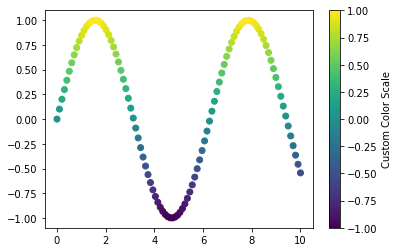

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create example data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Set the colormap (e.g., 'viridis', 'jet', 'cool', etc.)
colormap = 'viridis'

# Set the range of the color scale
vmin = -1
vmax = 1

# Create a scatter plot with the specified colormap and range
plt.scatter(x, y, c=y, cmap=colormap, vmin=vmin, vmax=vmax)

# Create the colorbar with the specified range
cbar = plt.colorbar()

# Add a label to the colorbar
cbar.set_label('Custom Color Scale')

# Show the plot
plt.show()

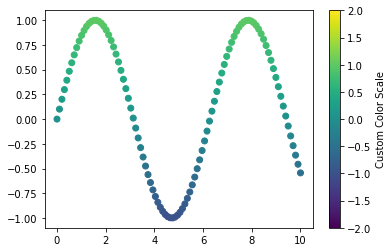

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create example data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Set the colormap (e.g., 'viridis', 'jet', 'cool', etc.)
colormap = 'viridis'

# Set the range of the color scale
vmin = -2
vmax = 2

# Create a scatter plot with the specified colormap and range
plt.scatter(x, y, c=y, cmap=colormap, vmin=vmin, vmax=vmax)

# Create the colorbar with the specified range
cbar = plt.colorbar()

# Add a label to the colorbar
cbar.set_label('Custom Color Scale')

# Show the plot
plt.show()